<h1><center>MSDS 7331: Data Mining Mini-Lab</center></h1>
<h3><center>Noelle Brown, John Heinen, Lizzy Sterling, and Matthew Rega</center></h3>

# Contents
### [Create Models](#Create Models)
### [Model Advantages](#Model Advantages)
### [Interpret Feature Importance](#Interpret Feature Importance)
### [Interpret Support Vectors](#Interpret Support Vectors)
### [Appendix](#Appendix)

___

<a id='Create Models'></a>

# Create Models

## Logistic Regression

**The following section explores predicting the Graduation Rate for public high schools in North Carolina using Logistic Regression.** 
* Using the Machine Learning Data for 2017 can we predict the Graduation Rate for public high schools?
* The North Carolina Educational Data Repository for Machine Learning is located on Github at: https://github.com/jakemdrew/EducationDataNC 
* This notebook was inspired by Dr. Jake Drew's 2017 Highly Segregated School notebook and contains shells of code used in that notebook.  We have updated to apply our particular goals, features, and decisions for predicting Graduation Rate.

**For documentation on various Generalized Linear Models in Sklearn see:**
* http://scikit-learn.org/stable/modules/linear_model.html
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python

**Prior to creating any models, the next three sections import and clean the North Carolina Public High School dataset for 2017.** 

**Import Data, create new feature and binary response variable**

In [7]:
#import required Libraries
import pandas as pd
import numpy as np

# Create new dataframe without including graduation rates of 0 
# "/Users/student/Desktop/Data_Mining/Project/PublicHighSchools2017_ML.csv"
path="https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/2017/Machine%20Learning%20Datasets/PublicHighSchools2017_ML.csv"
schooldata17=pd.read_csv(path)
schooldata17=schooldata17[schooldata17['4-Year Cohort Graduation Rate Score']>0]

#inspect data 
schooldata17.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455 entries, 0 to 469
Columns: 403 entries, student_num to unit_code
dtypes: float64(322), int64(81)
memory usage: 1.4 MB


In [8]:
#create the grad group column 
#low=4 year grad rate under 91%-------------has value of 0
#high=4 year grad rate above 91%------------has value of 1
schooldata17['4YearGradGroup']=np.where(schooldata17['4-Year Cohort Graduation Rate Score']<91,0,1)

#create the new feature of whether a school has majority of students that are Minority or not 
#MinorityPct under 50%-------------has value of 0
#MinorityPct above or equal to 50%------------has value of 1
schooldata17['Majority']=np.where(schooldata17['MinorityPct']<50,0,1)

**Review Target Data**
* We have created a boolean type classifier for High Graduation Rate (>=91%) and Low Graduation Rate (<91%).
* 216 Public High Schools have a Low Graduation Rate (47%).
* 239 Public High Schools have a High Graduation Rate (53%).

1    239
0    216
Name: 4YearGradGroup, dtype: int64


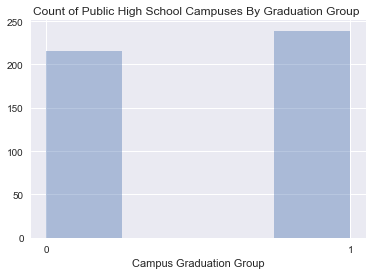

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
hst = sns.distplot(schooldata17['4YearGradGroup'], kde=False)
hst.set_xlabel("Campus Graduation Group")
#Assign output of plt.xticks() to x to surpress xticks() function output 
_ = plt.xticks([0,1])
_ = plt.title('Count of Public High School Campuses By Graduation Group ')
print(schooldata17['4YearGradGroup'].value_counts())
plt.show()

**Eliminate all Graduation Rate Attributes Data from Dataset**

In [9]:
#Identify columns to delete all Graduation Rate data from our dataset. 
GradCols = schooldata17.columns[(schooldata17.columns.str.lower().str.contains('graduationrate'))|
                           (schooldata17.columns.str.lower().str.contains('cohort'))|
                           (schooldata17.columns.str.lower().str.contains('gradgroup'))]
GradCols

Index([u'4-Year Cohort Graduation Rate Score', u'GraduationRate_5yr_All',
       u'GraduationRate_4yr_Female', u'GraduationRate_5yr_Female',
       u'GraduationRate_4yr_Male', u'GraduationRate_5yr_Male',
       u'GraduationRate_4yr_AmericanIndian',
       u'GraduationRate_5yr_AmericanIndian', u'GraduationRate_4yr_Asian',
       u'GraduationRate_5yr_Asian', u'GraduationRate_4yr_Black',
       u'GraduationRate_5yr_Black', u'GraduationRate_4yr_Hispanic',
       u'GraduationRate_5yr_Hispanic', u'GraduationRate_4yr_TwoorMoreRaces',
       u'GraduationRate_5yr_TwoorMoreRaces', u'GraduationRate_4yr_White',
       u'GraduationRate_5yr_White', u'GraduationRate_4yr_EDS',
       u'GraduationRate_5yr_EDS', u'GraduationRate_4yr_LEP',
       u'GraduationRate_5yr_LEP', u'GraduationRate_4yr_SWD',
       u'GraduationRate_5yr_SWD', u'GraduationRate_4yr_AIG',
       u'GraduationRate_5yr_AIG', u'4YearGradGroup'],
      dtype='object')

In [10]:
# create x explanatory and y response variables for regression
Y_GradRate = schooldata17['4YearGradGroup']
Y = Y_GradRate

#Delete all grad rate data from our dataset.
X_highSchools = schooldata17.drop(GradCols, axis=1)

#inspect data 
X_highSchools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455 entries, 0 to 469
Columns: 378 entries, student_num to Majority
dtypes: float64(296), int64(82)
memory usage: 1.3 MB


### Cross Validation
**Prior to performing Logistic Regression we will create our Cross Validation criteria.  Cross validation is performed using repeated holdout using ShuffleSplit().**
* Ten folds are used.
* The split is: 80% training data and 20% test data.
* A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [48]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

### Classifier Evaluation
** The following functions performs cross validation using cross_validate() for classification estimators and returns accuracy, precision, and recall.  These will be called several times throughout the notebook to evaluate models tested.** 

In [49]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X_highSchools, Y, scoring=['accuracy','precision','recall','r2','neg_mean_squared_error']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()
    #R2avg = scores['test_r2'].mean()
    #MSEavg = scores['test_neg_mean_squared_error'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"
    #print_str4 = "The average R-Squared for all cv folds is: \t\t\t {R2avg:.5}"
    #print_str5 = "The average Negative MSE for all cv folds is: \t\t\t {MSEavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    #print(print_str4.format(R2avg=R2avg))
    #print(print_str5.format(MSEavg=MSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']
    #scoresResults['R2'] = scores['test_r2']
    #scoresResults['MSE'] = scores['test_neg_mean_squared_error']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X_highSchools, Y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print (classReport)
    print (confMat)
    print (acc)

### Logistic Regression Model 1 - Principal Component Analysis (PCA)
**In this model we use PCA to try to identify the most important features in predicting graduation rate.**

In [50]:
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
#train_img, test_img, train_lbl, test_lbl = train_test_split( mnist.data, mnist.target, test_size=.2, random_state=0)
x_train, x_test, y_train, y_test=train_test_split(X_highSchools,Y,test_size=0.2, random_state=0)

#scale dataset
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(x_train)
# Apply transform to both the training set and the test set.
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95)

pca.fit(x_train)
pca.n_components_

print("In this PCA model, 95% of the variance amounts to", pca.n_components_, "principal components.")

In this PCA model, 95% of the variance amounts to 133 principal components.


In [51]:
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
logisticRegr.score(x_test, y_test)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(logisticRegr, x_test, y_test, cv)
EvaluateClassifierEstimator2(logisticRegr, x_test, y_test, 10)

The average accuracy for all cv folds is: 			 0.71868
The average precision for all cv folds is: 			 0.72774
The average recall for all cv folds is: 			 0.71993
*********************************************************
Cross Validation Fold Mean Error Scores
             precision    recall  f1-score   support

          0       0.68      0.67      0.68       216
          1       0.71      0.72      0.71       239

avg / total       0.70      0.70      0.70       455

[[145  71]
 [ 67 172]]
0.6967032967032967


## Logistic Regression Model 2 - Custom Parameters
**This model uses Logistic Regression to classify public high schools graduation rate in order to try to improve accuracy after trying PCA.**

**Please see documentation here: **
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [52]:
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(regEstimator, X_highSchools, Y, cv)
EvaluateClassifierEstimator2(logisticRegr, X_highSchools, Y, 10)

The average accuracy for all cv folds is: 			 0.71868
The average precision for all cv folds is: 			 0.72774
The average recall for all cv folds is: 			 0.71993
*********************************************************
Cross Validation Fold Mean Error Scores
             precision    recall  f1-score   support

          0       0.68      0.67      0.68       216
          1       0.71      0.72      0.71       239

avg / total       0.70      0.70      0.70       455

[[145  71]
 [ 67 172]]
0.6967032967032967


### Best Model - Logistic Regression Model 3 - Grid Search to Determine Top Parameters
**This model uses a grid search using our Custom Parameter model to determine the top parameters to use for our Logistic Regression model to further try to improve accuracy.**
* This proved to be the model with the best accuracy, so labeled the Best Model.  
* Additional Logistic Regression Model approaches tried: (see Appendix section of notebook)
  - Testing Scaled vs Unscaled Training Data
  - Recursive Feature Elimination (RFE)
  - RFE and Pipeline
  - Top 10 Parameters

In [53]:
#Create a grid search object 
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   16.5s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:   23.3s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', 'none'], 'random_state': [0], 'solver': ['lbfgs'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [54]:
#Diplay the top model parameters
regGridSearch.best_estimator_

LogisticRegression(C=1, class_weight='none', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.74505
The average precision for all cv folds is: 			 0.76051
The average recall for all cv folds is: 			 0.72989
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.758242,0.725000,0.725000
1,0.736264,0.809524,0.680000
2,0.725275,0.821429,0.534884
3,0.681319,0.738095,0.632653
4,0.802198,0.836735,0.803922
5,0.758242,0.750000,0.750000
6,0.758242,0.736842,0.857143
7,0.725275,0.688889,0.738095
8,0.725275,0.714286,0.760870
9,0.780220,0.784314,0.816327


In [56]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)

             precision    recall  f1-score   support

          0       0.70      0.75      0.73       216
          1       0.76      0.71      0.73       239

avg / total       0.73      0.73      0.73       455

[[163  53]
 [ 70 169]]
0.7296703296703296


In [58]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
X_highSchools_Scl = scaler.transform(X_highSchools)

#Create a classification estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

#Fit the model using all of the scaled training data
classifierEst.fit(X_highSchools_Scl, Y)
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools_Scl, Y, cv)
EvaluateClassifierEstimator2(classifierEst, X_highSchools_Scl, Y, 10)

The average accuracy for all cv folds is: 			 0.74505
The average precision for all cv folds is: 			 0.76051
The average recall for all cv folds is: 			 0.72989
*********************************************************
Cross Validation Fold Mean Error Scores
             precision    recall  f1-score   support

          0       0.70      0.75      0.73       216
          1       0.76      0.71      0.73       239

avg / total       0.73      0.73      0.73       455

[[163  53]
 [ 70 169]]
0.7296703296703296


## Support Vector Machine

The general concept of Support Vector Machines (SVMs) lies upon the concept of Maximum Margin Hyperplanes. When separating categorical data, the goal of the hyperplane is to separate the data while maintaining the largest margin between the closest points in each category to the plane. SVMs help to find this maximum margin. For our data, we are going to look at non-linear SVMs.

First we need to split our data into training and test data, where our training set contains 80% of our data and our test set contains the remaining 20%. 

In [11]:
# Code from https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb

from sklearn.model_selection import ShuffleSplit

if '4YearGradGroup' in schooldata17:
    y = schooldata17['4YearGradGroup'].values # get the labels we want
    del schooldata17['4YearGradGroup'] # get rid of the class label
    X = schooldata17.values

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

#splitting the data into train and test data
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices] 
    
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(364, 404)
(364,)
(91, 404)
(91,)


### SVM Model 1 - Un-Scaled

When approaching Support Vector Machines it is important to think about scaling. Each variable has a vastly different range. For example, the range for the value sat_avg_score_num and avg_daily_attend_pct are extremely different, as shown below. 

In [ ]:
print(schooldata17['sat_avg_score_num'].describe())
print(schooldata17['avg_daily_attend_pct'].describe())

The range for sat_avg_score_num is [0,1404] and the range of avg_daily_pct is [.85,1]. 

We are going to show that this will cause issues by running our Support Vector Machine Model without scaling our data. 

In [120]:
from sklearn.svm import SVC
from sklearn import metrics as mt 
from sklearn.metrics import confusion_matrix

# train svm model
svm_model = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto')
svm_model.fit(x_train, y_train)  

#here, we need to scale the test data from the outcome of the fitted training data
svc_test_preds = svm_model.predict(x_test)

acc = mt.accuracy_score(y_test,svc_test_preds)
conf = mt.confusion_matrix(y_test,svc_test_preds)
print('Accuracy:', acc )
print('')
print(conf)
print('')
print('MSE test:', mt.mean_squared_error(y_test,svc_test_preds))
print('')

Accuracy: 0.428571428571

[[ 0 52]
 [ 0 39]]

MSE test: 0.571428571429



The accuracy is 42%, which is very low and the MSE test error is .57 which is very high. Looking at the confusion matrix, there were 0 classifications to the low graduation group, whether correct or not. Therefore there is a very high false positive rate. For our data set, we do not want a high rate of false positives. If a school that has a low graduation rate and is classified incorrectly it may not receive the help and changes necessary to improve their graduation rate. Therefore we need to try scaling our data.  

### SVM Model 2 - Scaled

In order to scale our data, we are going to use the scikit-learn package StandardScaler, which removes the mean and scales to the unit variance. We only fit our training data because fitting our test data would defeat the purpose of splitting the data into test and train. We then create two new variables that transform both the training and test set so that all of the variables are scaled. 


In [12]:
#we only need to scale the training aspect of the data - training the test as well would be "cheating"
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()
scl_obj.fit(X_train)

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test)

We will use the scikit-learn package, SVC, to classify our support vectors. The only value we will change from the default is the penalty parameter, C.  By using a value of .5 the decision surface will be smoother than the default value of 1.

We will then fit the model to the training data and then predict using the scaled x_train data. 


In [14]:
from sklearn.svm import SVC
from sklearn import metrics as mt 

# train svm model
svm_model = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto')
svm_model.fit(X_train_scaled, y_train)  

#here, we need to scale the test data from the outcome of the fitted training data
svc_test_preds = svm_model.predict(X_test_scaled)

acc = mt.accuracy_score(y_test,svc_test_preds)
conf = mt.confusion_matrix(y_test,svc_test_preds)
print('Accuracy:', acc )
print('')
print(conf)
print('')
print('MSE test:', mt.mean_squared_error(y_test,svc_test_preds))
print('')

('Accuracy:', 0.7692307692307693)

[[31 12]
 [ 9 39]]

('MSE test:', 0.23076923076923078)



The accuracy has significantly improved to 76.9% and the MSE for the test set has significantly decreased to .23. The confusion matrix also gives us much more confidence in the model. The false positive rate has significantly decreased and both of the false classification rates are less than half of their true classification rates, which is a good sign.



In [15]:
# look at the support vectors
print(svm_model.support_vectors_.shape)
print(svm_model.support_.shape)
print(svm_model.n_support_ )

(289, 404)
(289,)
[136 153]


Finally we can look at our classification report.

In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test,svc_test_preds))

             precision    recall  f1-score   support

          0       0.78      0.72      0.75        43
          1       0.76      0.81      0.79        48

avg / total       0.77      0.77      0.77        91



With an overall precision of 77%, a recall of 77% and a f-1 score of .77,which is just just a combination of the previous two values, we know we have a well-fitted model.

___

<a id='Model Advantages'></a>

# Model Advantages

The dataset that we use is very wide, with 378 features available to classify the target of graduation rate (4YearGradGroup).  We only have 455 records of high schools.  The small number of records could have had an impact on accuracy rate as we trained this data to predict graduation rate.  We used an 80% training, 20% test split with a 10-fold cross validation.  We also created a binary classification of the graduation rate variable where 1 corresponded to greater than or equal to 91% (the median graduation rate).  0 corresponds to high schools with a graduation rate of less than 91%.

The first logistic regression model we tried included running Principal Component Analysis (PCA) on our dataset.  We found that 133 of the 378 features explained 95% of the variance amounts in the PCA model.  After running logistic regression, using the default parameters for LogisticRegression in sklearn, our overall accuracy for this model was 69.7%.

In the next logistic regression model, we ran LogisticRegression on our entire dataset with some custom parameters in the function.  Our overall accuracy for this model was exactly the same as the accuracy in PCA, 69.7%.

In our next model, we then used GridSearchCV to perform a hyperparameter search on our entire dataset to find the best combination of parameters for our data.  We used this result of best parameters in our LogisticRegression function to predict graduation rate.  Our overall accuracy increased to 73%.  After looking at some initial Feature Importance, we realized we needed to scale the data in order to determine the true features of importance by weights.  Before scaling, we received very strange features as important that did not make sense for predicting graduation rate.  After scaling, the features of importance were more of what we would expect for predicting graduation rate, so we learned the importance of scaling the data.  This also had no impact on our overall accuracy of 73%.

We performed additional logistic regression models to try to increase overall accuracy, but with no success.  These additional models, using Recursive Feature Elimination (RFE), RFE and Pipeline, Top 10 Features, and Scaled and Unscaled Data, can be found in the Appendix.

After our all our logistic regression testing on this data set, the philosophy of Occam’s razor was proved out and one of our simplest models, Model 3 was sufficient for best accuracy.  This model also runs very quickly, which is mostly due to our smaller dataset size, but there was some latency when running the more complex models including RFE and Pipeline.

When looking at Support Vector Machines, we tried two models: un-scaled and scaled. The un-scaled model had a very low accuracy of 42% and a high Mean Squared Error of .57. Beacause this was not a well-fitting model, we went ahead with a scaled model. Our scaled model has a 76% accuracy rate and a Mean Squared Error of .23 when applied to the test set. Therefore we went forward with further analysis of the scaled model. 

We found that the model has a high precision as well as a high recall and f1-score. The confusion matrix also indicates that the false positive and false negative are significantly lower than the true classifications.

Overall, both our scaled support vector machine as well as our third LogisticRegression model perfomed very well, but our support vector machine works slightly better. 



___

<a id='Interpret Feature Importance'></a>

# Interpret Feature Importance

### Best Model - Logistic Regression Model 3 - Grid Search to Determine Top Parameters
**In this section we will identify the features of interest and interpret how these features relate to the classification task of graduation rate.**

**Determining Feature Importance**

In [59]:
#Create a classification estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

#Fit the model using all of the scaled training data
classifierEst.fit(X_highSchools_Scl, Y)

from sklearn.metrics import confusion_matrix

In [60]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = classifierEst.coef_.ravel()
feature_names = X_highSchools.columns.values
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

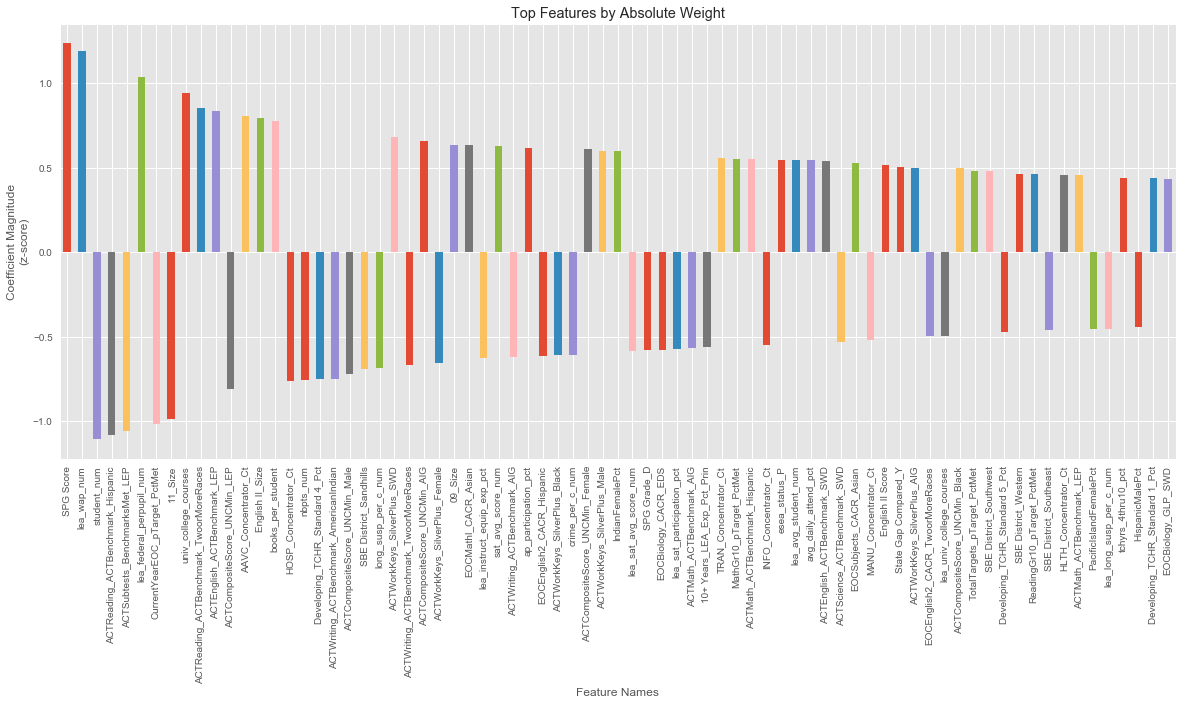

In [61]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(75)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Features by Absolute Weight")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

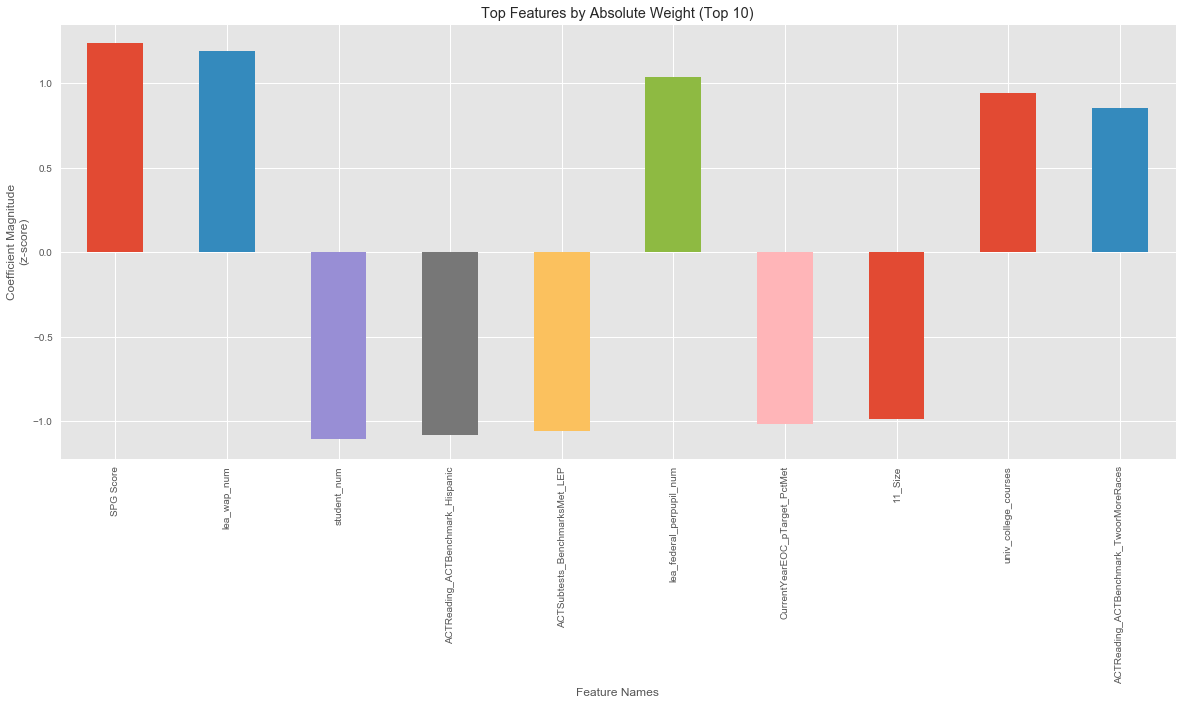

In [62]:
##Focus Chart on top 10 features for discussion
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(10)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Features by Absolute Weight (Top 10)")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

**Interpreting Feature Importance**

In the chart above we identify the top 75 features, sorted by importance using the absolute weight of the feature for classifying graduation rate.  As the chart shows, the top feature is SAT test average score for a high school.  This feature is positively correlated to graduation rate and would indicate that the higher this number, the higher the graduation rate. The fact that this bar rises above the x-axis marks the positive correlation.  In contrast, the next two important features are negatively correlated (going below the x-axis) to graduation rate.  The first of these is the average age media collection of the school. This relationship makes sense because one would think that if the school has older books, students are not learning the most up to date information which could impact graduation. Additionally having old books could be a reflection of the funding the school is receiving. Some of these schools might not have the money to afford all new books for their students which is why their media collection is old. If a school does not have money for books there is a high chance they do not have money for other things like supplies or salaries for their teachers. This average age of media collection might be representing the funding or available money a school has which would be the underlying cause of the negatively correlated relationship with graduation rate. 

The next variable that has a negative correlation is student number. This relationship supports the age old notion that students learn better in smaller class sizes. If a student is in a smaller class than the teacher has a more direct connection with them and can individualize the lesson plan a little more than in a big class. While this variable does not say anything about a student to teacher relationship it is a fair assumption that schools with a higher enrollment tend to have a higher student to teacher ratio as well. This would explain the negatively correlated relationship with graduation rate. Since the school is bigger, the classes are bigger, which makes it harder for a teacher to spend time with a struggling student because they have a class of 30 students instead of 15. Students could slip through the cracks in this scenario and start performing poorly in their classes which would cause them to not graduate.

Something interesting to note is that of the top seven variables five of them are negatively correlated with graduation rate. All of these variables are lowering the predicted graduation rate of a school, unless they are zero but that would be very unlikely. This is interesting because it is suggesting for a school to have a high graduation rate they should not focusing on having the highest scores or most after school programs but rather they want to have a low enrollment or a new media collection. There are two positively correlated variables in the top seven and the majority of the other highly ranked variables are also positively correlated so a school having a high value for these variables would obviously help them improve their graduation rate. However, it is worth noting that a good majority of the top ranked variables are all negatively correlated with graduation rate.


___

<a id='Interpret Support Vectors'></a>

# Interpret Support Vectors

To properly begin to interpret our support vectors, we first need to create a DataFrame of our training data and add back in our response column, ‘4YearGradGroup’.


In [18]:
# make a dataframe of the training data
schooldata17_tested_on = schooldata17.iloc[train_indices]
# now get the support vectors from the trained model
schooldata17_support = schooldata17_tested_on.iloc[svm_model.support_,:]
#schooldata17_support2 = pd.DataFrame(x_train_scaled).iloc[svm_model.support_,:]

schooldata17_support['GradGroup'] = Y_GradRate[svm_model.support_] # add back in the 'GradGroup' Column to the pandas dataframe
schooldata17['GradGroup'] = Y_GradRate # also add it back in for the original data
schooldata17_support.info()

/Users/lizzysterling/anaconda2/lib/python2.7/site-packages/pandas/core/series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 11 to 155
Columns: 405 entries, student_num to GradGroup
dtypes: float64(323), int64(82)
memory usage: 916.7 KB


/Users/lizzysterling/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


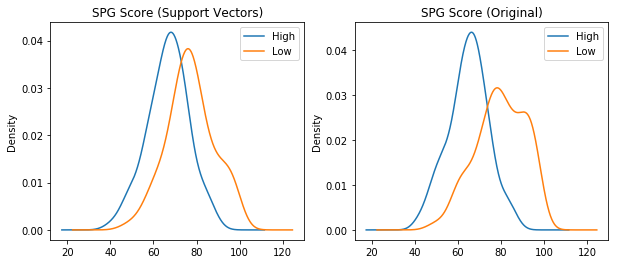

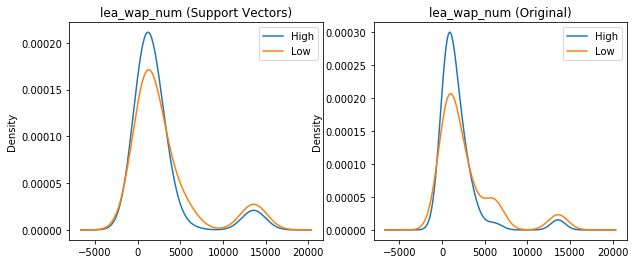

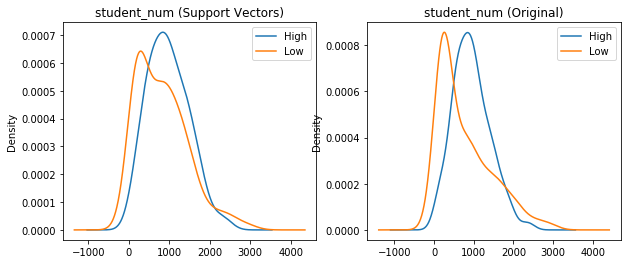

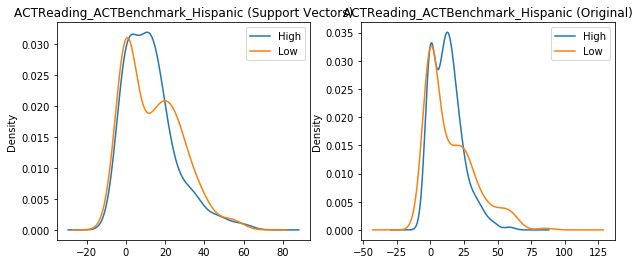

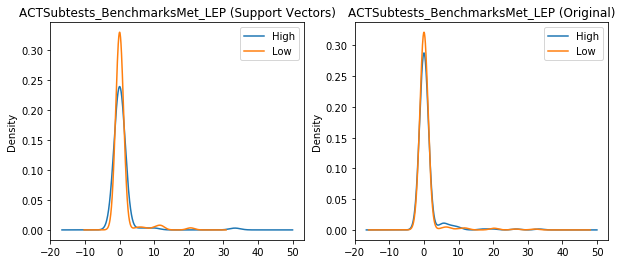

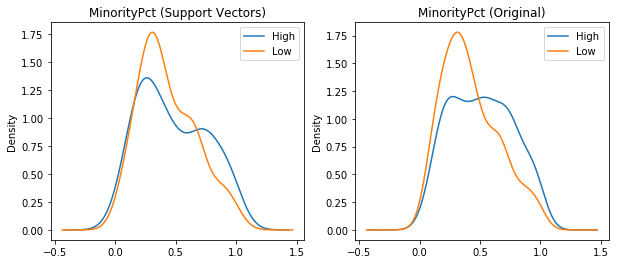

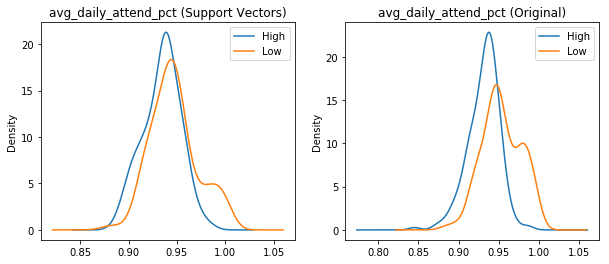

In [23]:
# plot support vectors

from pandas.tools.plotting import boxplot
import matplotlib.pyplot as plt

# group the original data and the support vectors
schooldata17_grouped_support = schooldata17_support.groupby(['GradGroup'])
schooldata17_grouped = schooldata17.groupby(['GradGroup'])

# plot KDE of Different variables
vars_to_plot = ['SPG Score','lea_wap_num','student_num', 'ACTReading_ACTBenchmark_Hispanic', 'ACTSubtests_BenchmarksMet_LEP','MinorityPct','avg_daily_attend_pct']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    #the line below is the issue - works if you do not use the grouped data
    # but does not plot both groups: az = schooldata17_support[v].plot.kde()
    ax = schooldata17_grouped_support[v].plot.kde() 
    plt.legend(['High','Low'])
    plt.title(v+' (Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = schooldata17_grouped[v].plot.kde() 
    plt.legend(['High','Low'])
    plt.title(v+' (Original)')
    
plt.show()

With these plots we are looking at the original statistics as well as the statistics of the support vectors. 

- SPG Score: this variable, which is the school performace grade, the distribution of the support vectors is closer between the high and low groups than the original data. 
- lea_wap_num: this variable, which measures the wireles applications of different school districts, has a slightly closer distribution of the support vectors than the original data, but it is not vastly different. A notable point is ~6000 where there is a bump in the original data that cannot be seen in the support vectors. 
- student_num: this variable, which is the number of students, has a slightly different distribution of the support vectors when compared to the original data. The distribution of the both of the groups is wider than the original data distribution.
- ACTReading_ACTBenchmark_Hispanic: this variable, which takes count of the ACT benchmark for the reading section for hispanics, has a wider distribution of support vectors than the original data distribution.
- ACTSubtests_BenchmarksMet_LEP: this variable, which is another variable that takes into account meeting ACT benchmarks, has a similar distribution of support vectors to original data aside from the support vectors having a slightly greater separation. 

___

# Appendix

**This section includes additional work tried to improve model performance.**

### Logistic Regression Model - Testing Scaled vs. Unscaled Training Data

**Cross validation is performed using both scaled and unscaled training data.**
* A grid search is also performed on the scaled training data to determine the best parameters to use with the scaled training data.
* We scale the data prior to looking at feature importances.  Since the raw features have different dynamic ranges, scaling the data first allows us to compare the model's coefficients accurately. 
* The scaled data makes more accurate predictions in many cases but not always, it is more accurate than our custom model, but not just as accurate as our top parameter model.

In [24]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
X_highSchools_Scl = scaler.transform(X_highSchools)

**In this case, we tested scaling the data before cross validation as well.**

In [25]:
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced','none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(regEstimator, X_highSchools, Y, cv)

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools_Scl, Y)

The average accuracy for all cv folds is: 			 0.71868
The average precision for all cv folds is: 			 0.72774
The average recall for all cv folds is: 			 0.71993
*********************************************************
Cross Validation Fold Mean Error Scores
Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:    9.7s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', 'none'], 'random_state': [0], 'solver': ['lbfgs'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [26]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [27]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools_Scl, Y, cv)

The average accuracy for all cv folds is: 			 0.72088
The average precision for all cv folds is: 			 0.77615
The average recall for all cv folds is: 			 0.62621
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.703297,0.782609,0.450000
1,0.725275,0.790698,0.680000
2,0.725275,0.736842,0.651163
3,0.692308,0.783784,0.591837
4,0.791209,0.863636,0.745098
5,0.681319,0.758621,0.500000
6,0.802198,0.844444,0.775510
7,0.736264,0.736842,0.666667
8,0.681319,0.707317,0.630435
9,0.670330,0.756757,0.571429


In [28]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools_Scl, Y, 10)

             precision    recall  f1-score   support

          0       0.65      0.80      0.72       216
          1       0.77      0.62      0.69       239

avg / total       0.72      0.70      0.70       455

[[173  43]
 [ 92 147]]
0.7032967032967034


In [29]:
Y.value_counts()

1    239
0    216
Name: 4YearGradGroup, dtype: int64

## Feature Importance for Logistic Regression Model - Testing Scaled Data
**Here we look at the features driving the Model 3's decisions.**
* All training data is scaled to remove differences in coefficient scales since many features have different dynamic ranges.
* A final model is created using all the scaled training data.  
* All model coefficients are sorted by absolute value in descending order.
* Sorted coefficient values are plotted showing the top 75 features with the strongest positive and negative correlations. 

In [30]:
#Create a classification estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

#Fit the model using all of the scaled training data
classifierEst.fit(X_highSchools_Scl, Y)

from sklearn.metrics import confusion_matrix

In [31]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = classifierEst.coef_.ravel()
feature_names = X_highSchools.columns.values
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

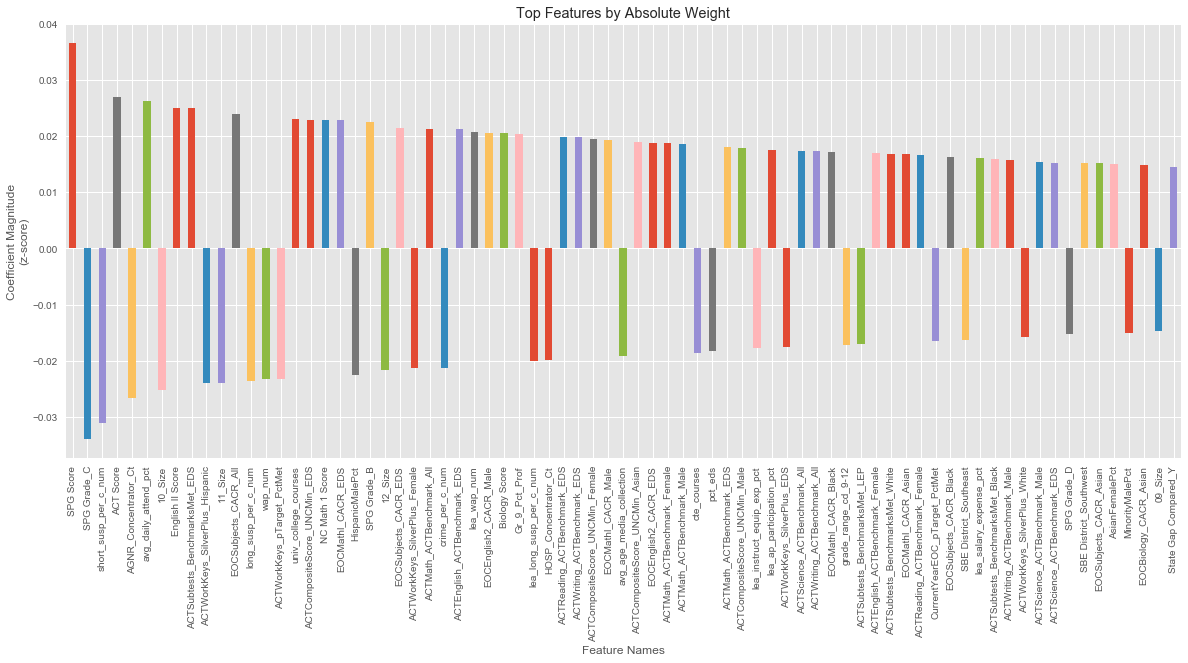

In [32]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(75)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Features by Absolute Weight")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

### Logistic Regression Model -  Recursive Feature Elimination (RFE)
#### Feature Importance Using Recursive Feature Elimination
**Please see the following documentation for this section**
* http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
* http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
* http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV
* https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models

In [45]:
from sklearn.feature_selection import RFECV

#Create a regression estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
rfecv.fit(X_highSchools, Y)

EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.72088
The average precision for all cv folds is: 			 0.77615
The average recall for all cv folds is: 			 0.62621
The average Negative MSE for all cv folds is: 			 -0.27912
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall,MSE
0,0.703297,0.782609,0.450000,-0.296703
1,0.725275,0.790698,0.680000,-0.274725
2,0.725275,0.736842,0.651163,-0.274725
3,0.692308,0.783784,0.591837,-0.307692
4,0.791209,0.863636,0.745098,-0.208791
5,0.681319,0.758621,0.500000,-0.318681
6,0.802198,0.844444,0.775510,-0.197802
7,0.736264,0.736842,0.666667,-0.263736
8,0.681319,0.707317,0.630435,-0.318681
9,0.670330,0.756757,0.571429,-0.329670


Optimal number of features : 4


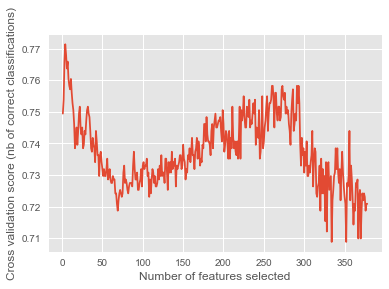

In [46]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [47]:
#Plot the RFE Rankings
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':X_highSchools.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )

top50features = rfe_ft_imp_df.head(50)

top50features

,feature_names,weights
3,09_Size,0.771429
4,10_Size,0.768132
2,st_avg_student_num,0.765934
6,12_Size,0.765934
5,11_Size,0.763736
7,Biology_Size,0.760440
10,lea_total_expense_num,0.760440
290,INFO_Concentrator_Ct,0.758242
272,IndianFemalePct,0.758242
8,English II_Size,0.758242


### Logistic Regression Model 5 - Top 10 Correlation Features
* In this model we used the top 10 correlation features from Model 3 to see if we could improve accuracy.

In [60]:
from sklearn import datasets, linear_model
#make model with top 10 variables from Correlation Plot Above

x_train, x_test, y_train, y_test=train_test_split(X_highSchools,Y,test_size=0.2)
top_10_x_train, top_10_x_test, y_train, y_test=train_test_split(X_highSchools[['SPG Score','SPG Grade_C','short_susp_per_c_num','ACT Score','AGNR_Concentrator_Ct','avg_daily_attend_pct','10_Size','English II Score','ACTSubtests_BenchmarksMet_EDS','ACTWorkKeys_SilverPlus_Hispanic']],Y,test_size=0.2)
lm=linear_model.LogisticRegression()

all_vars=lm.fit(x_train,y_train)
top_10_model=lm.fit(top_10_x_train,y_train)

In [61]:
#All and top 10 model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#score and find the MSE of the model for the train and test sets

#score models
top_10_test_preds=top_10_model.predict(top_10_x_test)
top_10_train_preds=top_10_model.predict(top_10_x_train)

#calculate MSE
print('MSE train for Top 10 Model is:', mean_squared_error(y_train,top_10_train_preds))
print('MSE test Top 10 Model is:', mean_squared_error(y_test,top_10_test_preds))

print('')

#accuracy
print('Accuracy train Top 10 Model is:', accuracy_score(y_train,top_10_train_preds))
print('Accuracy test Top 10 Model is:', accuracy_score(y_test,top_10_test_preds))

MSE train for Top 10 Model is: 0.21153846153846154
MSE test Top 10 Model is: 0.26373626373626374

Accuracy train Top 10 Model is: 0.7884615384615384
Accuracy test Top 10 Model is: 0.7362637362637363


###  Logistic Regression Model 6 - Recursive Feature Elimination and Pipeline
1. Use recursive feature elimination to select the best features for predicting graduation rate.
2. Create a pipeline to scale the training data then perform logistic regression.
3. Create logistic regression parameters to test within the pipeline. 
4. Use a grid search to find the best parameters based on classification accuracy. 
5. Perform 10-fold cross valication and look at individual fold performance.  
6. Look at the classification report, confusion_matrix, and accuracy_score from sklearn.metrics for detailed performance analysis. 

In [48]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit

#Use recursive feature elimination to get the best features for our model
#(We already did this earlier, but I am including it again below in comment for a complete example!)

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
X_BestFeatures = rfecv.fit_transform(X_highSchools, Y)

#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# Define a range of hyper parameters for grid search
parameters = { 'logisticregression__penalty':['l2']
              ,'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'logisticregression__class_weight': ['balanced','none']
              ,'logisticregression__random_state': [0]
              ,'logisticregression__solver': ['lbfgs']
              ,'logisticregression__max_iter':[100,500]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy')

#Use the best features from recursive feature elimination during the grid search
grid.fit(X_BestFeatures, Y)

#display the best pipeline model identified during the grid search
grid.best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

In [62]:
EvaluateClassifierEstimator(grid.best_estimator_, X_BestFeatures, Y, cv)

The average accuracy for all cv folds is: 			 0.72527
The average precision for all cv folds is: 			 0.73804
The average recall for all cv folds is: 			 0.71404
The average Negative MSE for all cv folds is: 			 -0.27473
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall,MSE
0,0.747253,0.707317,0.725000,-0.252747
1,0.736264,0.809524,0.680000,-0.263736
2,0.670330,0.644444,0.674419,-0.329670
3,0.736264,0.804878,0.673469,-0.263736
4,0.714286,0.735849,0.764706,-0.285714
5,0.703297,0.729730,0.613636,-0.296703
6,0.758242,0.775510,0.775510,-0.241758
7,0.747253,0.720930,0.738095,-0.252747
8,0.703297,0.686275,0.760870,-0.296703
9,0.736264,0.765957,0.734694,-0.263736


In [63]:
EvaluateClassifierEstimator2(grid.best_estimator_, X_BestFeatures, Y, 10)

             precision    recall  f1-score   support

          0       0.71      0.75      0.73       216
          1       0.76      0.72      0.74       239

avg / total       0.74      0.74      0.74       455

[[163  53]
 [ 67 172]]
0.7362637362637363
